## **Fetch Rewards Take-Home Exercise - Machine Learning Engineer**

###Instructions

At Fetch, we are monitoring the number of the scanned receipts to our app on a daily base as one of our KPIs. From business standpoint, we sometimes need to predict the possible number of the scanned receipts for a given future month.

The following link (https://fetch-hiring.s3.amazonaws.com/machine-learning-engineer/receipt-count-prediction/data_daily.csv) provides the number of the observed scanned receipts each day for the year 2021.

Based on this prior knowledge, develop an algorithm which can predict the approximate number of the scanned receipts for each month of 2022.



In [2]:
#Import the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet

In [5]:
# Import the data

data = pd.read_csv('data_daily.csv')

In [6]:
# Print out the shape of the data and the first 5 rows

print(f'Shape of the Dataset: {data.shape}')
data.head()

Shape of the Dataset: (365, 2)


,# Date,Receipt_Count
0,2021-01-01,7564766
1,2021-01-02,7455524
2,2021-01-03,7095414
3,2021-01-04,7666163
4,2021-01-05,7771289


We can see that this dataset has two columns:
1. #Date: All days from the year 2021
2. Receipt_Count: Total number of the observed scanned receipts each corresponding date

Let's do some preprocessing steps before we perform some exploration in order to understand the data further.

###**Data Preprocessing Steps**

In [8]:
# Rename the data set columns to something that is more convenient for use

data.columns = ['Date', 'Total_Receipt']

In [58]:
# Check for missing values

data.isnull().sum()

Date             0
Total_Receipt    0
dtype: int64

In [59]:
# Check types of the dataset using the info()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Date           365 non-null    object
 1   Total_Receipt  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [60]:
# Check for duplicates

print("Number of rows that are duplicated:", data.duplicated().sum())

Number of rows that are duplicated: 0


So summing up:
1. We have no missing values in the dataset
2. We have no duplicate rows in the dataset

However, the date column is of type 'Object' so we would like to change that to the appropriate date time.

In [9]:
# Convert 'Date' column to datetime format

data['Date'] = pd.to_datetime(data['Date'])
data.info() # Can also do data['Date'].dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           365 non-null    datetime64[ns]
 1   Total_Receipt  365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


### **Exploratory Data Analysis**

In [62]:
# Summary Statistics (mainly Total_Receipt)

data.describe()

,Total_Receipt
count,3.650000e+02
mean,8.826566e+06
std,7.820089e+05
min,7.095414e+06
25%,8.142874e+06
50%,8.799249e+06
75%,9.476970e+06
max,1.073886e+07


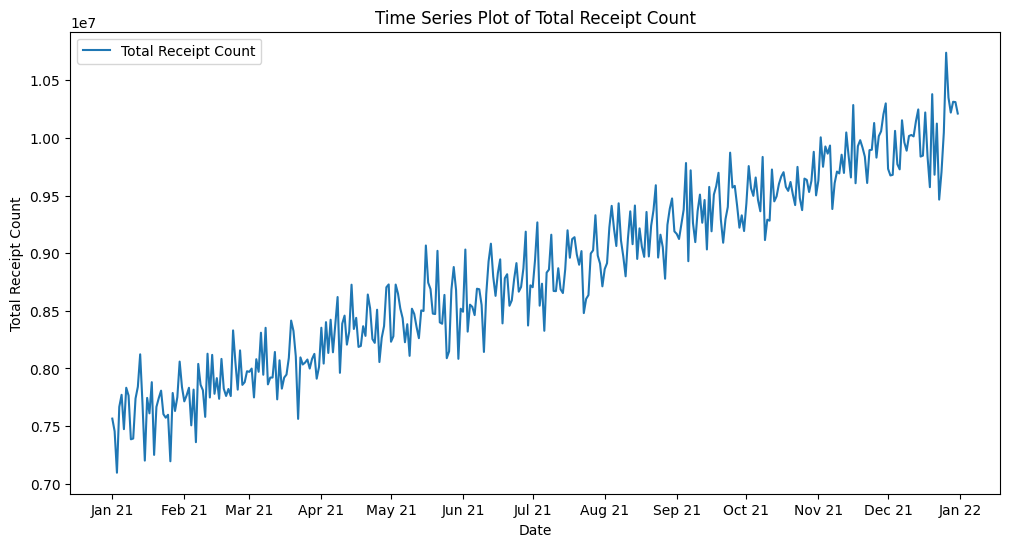

In [128]:
# Plot the distribution of the total receipts for each day in the year 2021
plt.plot(data['Date'], data['Total_Receipt'], label='Total Receipt Count', linestyle='-')

# Titles and Axis Titles
plt.title('Time Series Plot of Total Receipt Count')
plt.xlabel('Date')
plt.ylabel('Total Receipt Count')

# Legend
plt.legend()

# Formatting the x axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

plt.show()

ADF Statistic: 0.1750441657200558
p-value: 0.9708266454651425


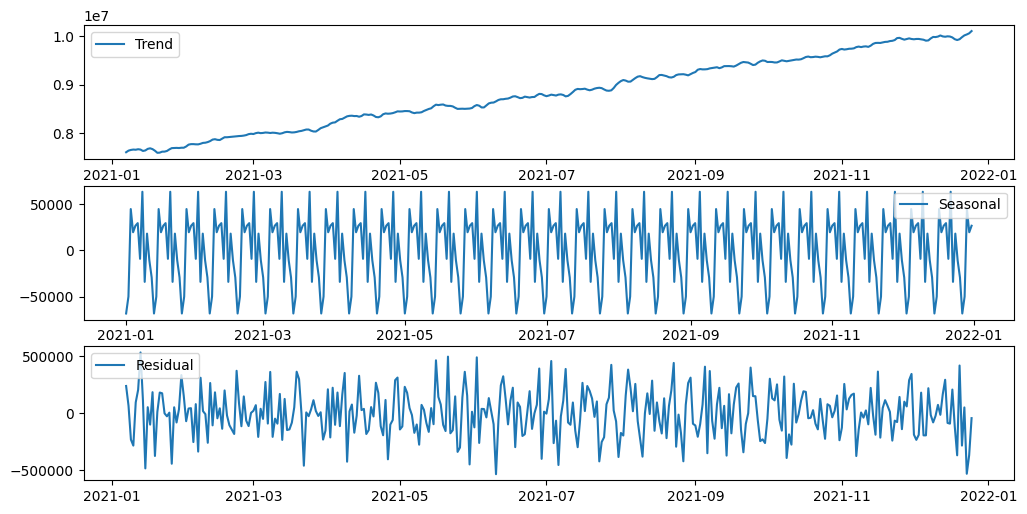

In [81]:
# Performing seasonal decomposition to understand the trend and seasonality of the time series using an additive model

data_copy = data.set_index('Date')
result = seasonal_decompose(data_copy['Total_Receipt'], model='additive', period=12)

# Additionally perform Dickey Fuller test to check for stationarity

ad_test = adfuller(data['Total_Receipt'])
print('ADF Statistic:', ad_test[0])
print('p-value:', ad_test[1])


# Plot the components separately
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(result.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.show()

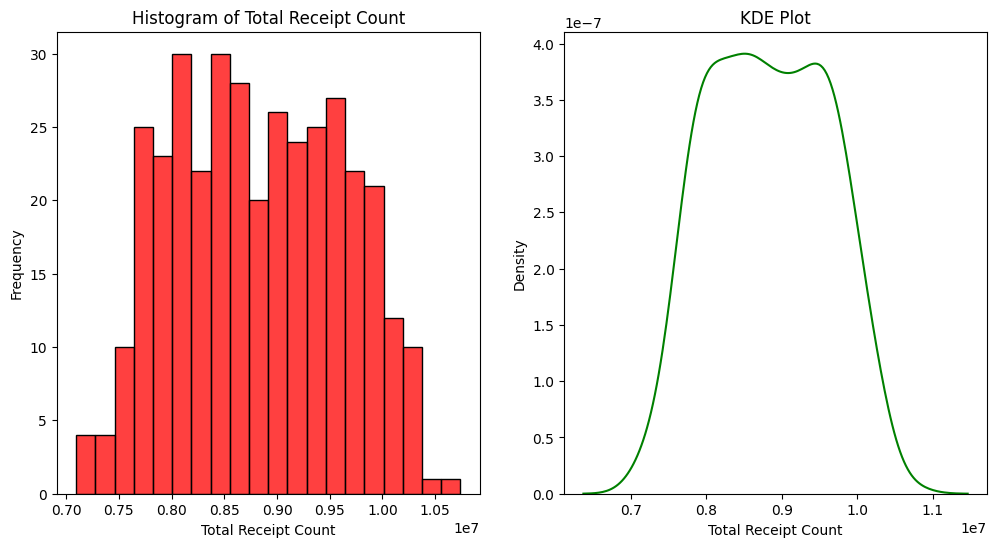

In [122]:
# Plotting the distribution of the time series data using a histogram, KDE and box plots

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(data['Total_Receipt'], kde=False, bins=20, color='red')
plt.title('Histogram of Total Receipt Count')
plt.xlabel('Total Receipt Count')
plt.ylabel('Frequency')

# KDE
plt.subplot(1, 2, 2)
sns.kdeplot(data['Total_Receipt'], color='green')
plt.title('KDE Plot')
plt.xlabel('Total Receipt Count')
plt.ylabel('Density')

plt.show()

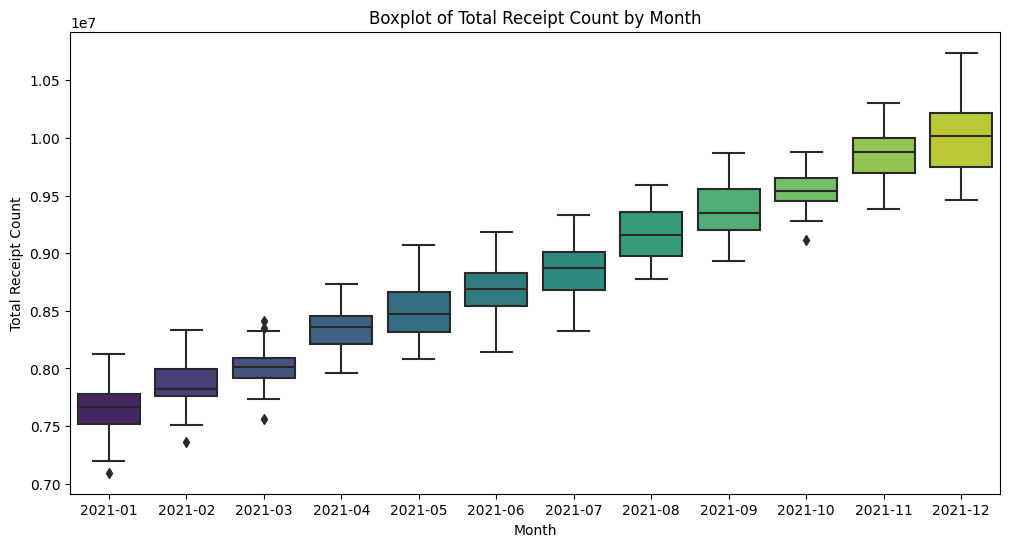

In [121]:
# Boxplot
sns.boxplot(x=data['Date'].dt.to_period('m'), y=data['Total_Receipt'], palette='viridis')
plt.title('Boxplot of Total Receipt Count by Month')
plt.xlabel('Month')
plt.ylabel('Total Receipt Count')

plt.show()

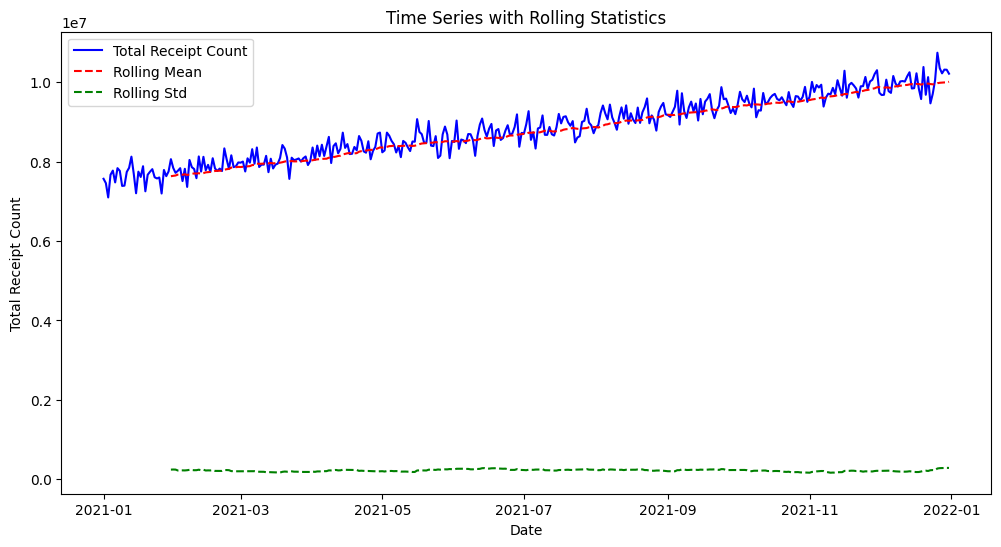

In [129]:
# Rolling Statistics - Looking at the mean and std in the previous 30 days for each data point
plt.plot(data['Date'], data['Total_Receipt'], label='Total Receipt Count', linestyle='-', color='blue')

# Rolling Mean
rolling_mean = data['Total_Receipt'].rolling(window=30).mean()
plt.plot(data['Date'], rolling_mean, label='Rolling Mean', linestyle='--', color='red')

# Rolling Standard Deviation
rolling_std = data['Total_Receipt'].rolling(window=30).std()
plt.plot(data['Date'], rolling_std, label='Rolling Std', linestyle='--', color='green')

plt.title('Time Series with Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Total Receipt Count')
plt.legend()
plt.show()

### **Building a Model**


###### **Building an Arima Model**

In [38]:
# Fabricate data for 2022
start_date_2022 = pd.to_datetime('2022-01-01')
end_date_2022 = pd.to_datetime('2022-12-31')
months_2022 = pd.date_range(start=start_date_2022, end=end_date_2022, freq='MS')

fabricated_data_2022_monthly = pd.DataFrame({'Date': months_2022})
fabricated_data_2022_monthly['Total_Receipt'] = np.nan
#fabricated_data_2022_monthly['Date'] = fabricated_data_2022_monthly['Date'].dt.to_period("M")

print(fabricated_data_2022_monthly.shape)
fabricated_data_2022_monthly.head()

(12, 2)


,Date,Total_Receipt
0,2022-01-01,NaN
1,2022-02-01,NaN
2,2022-03-01,NaN
3,2022-04-01,NaN
4,2022-05-01,NaN


<ipython-input-11-1ecd3e61e9ce>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_data_2021 = data.groupby(data['Date'].dt.to_period("M")).sum()


ADF Statistic: -3.366862225297933
p-value: 0.012141761680413447


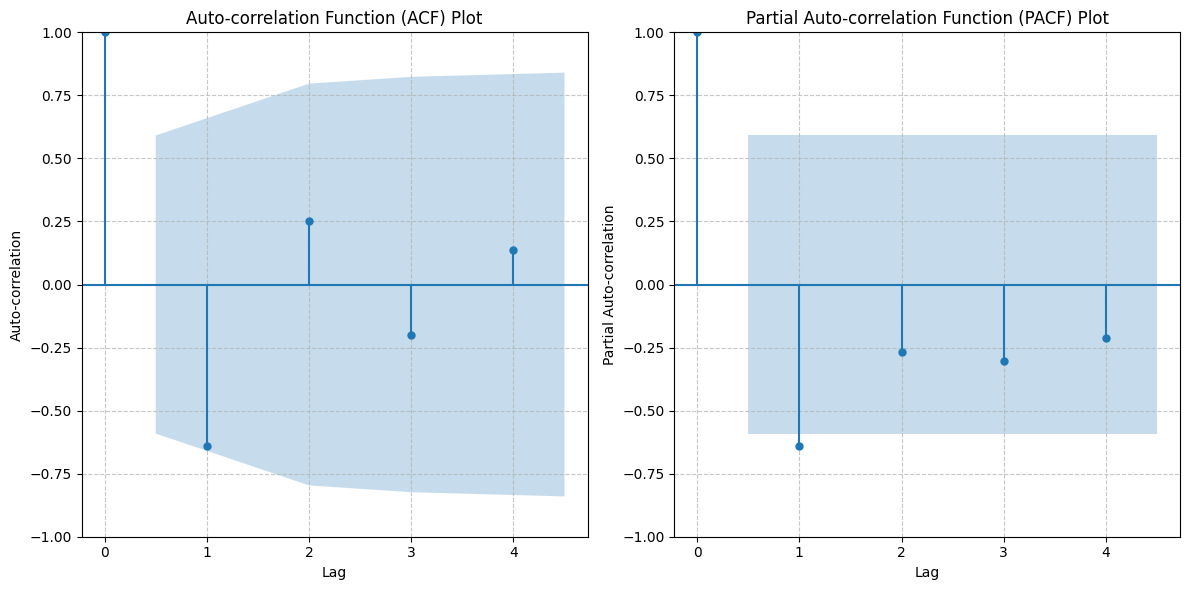

In [11]:
# Auto-correlation Function (ACF) and Partial Auto-correlation Function (PACF) Plot for the time series data after differencing to make the data stationary
monthly_data_2021 = data.groupby(data['Date'].dt.to_period("M")).sum()
plt.figure(figsize=(12, 6))

# Dickey Fuller test after differencing

data_diff = monthly_data_2021['Total_Receipt'].diff().dropna()
result = adfuller(data_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


# ACF Plot
plt.subplot(1, 2, 1)
acf_plot = sm.graphics.tsa.plot_acf(data_diff, lags=4, ax=plt.gca())
plt.title('Auto-correlation Function (ACF) Plot')
plt.xlabel('Lag')
plt.ylabel('Auto-correlation')
plt.grid(True, linestyle='--', alpha=0.7)


# PACF Plot
plt.subplot(1, 2, 2)
pacf_plot = sm.graphics.tsa.plot_pacf(data_diff, lags=4, ax=plt.gca())
plt.title('Partial Auto-correlation Function (PACF) Plot')
plt.xlabel('Lag')
plt.ylabel('Partial Auto-correlation')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [12]:
# Scale the data using a StandardScaler()

scaler = StandardScaler()
data_scaled = monthly_data_2021.copy()
data_scaled['Total_Receipt'] = scaler.fit_transform(data_scaled[['Total_Receipt']])

In [13]:
# Fit ARIMA model with different parameters and choose the best one

p_range = 4
q_range = 4
d_range = 2
y = data_scaled['Total_Receipt']

best_mae = float('inf')
best_mse = float('inf')
best_model = None
best_arima_model = None
best_predictions = None

for p in range(1, p_range):
    for d in range(1, d_range):
        for q in range(1, q_range):
            arima_model = ARIMA(y, order=(p, d, q))
            arima_result = arima_model.fit()

            predictions = arima_result.fittedvalues

            # Inverse transform predictions to the original scale
            predictions_original_scale = scaler.inverse_transform(predictions.values.reshape(-1, 1)).flatten()

            # Calculate MAE and MSE
            mae = mean_absolute_error(monthly_data_2021['Total_Receipt'], predictions_original_scale)
            mse = mean_squared_error(monthly_data_2021['Total_Receipt'], predictions_original_scale)

            print(f"ARIMA({p},{d},{q}) - MAE: {mae:.2f}, MSE: {mse:.2f}")

            # Update best model if the current model is better
            if mae < best_mae:
                best_mae = mae
                best_mse = mse
                best_model = f"ARIMA({p},{d},{q})"
                best_arima_model = arima_result  # Store the ARIMA model object
                best_predictions = predictions_original_scale.copy()

print(f"Best Model: {best_model} - Best MAE: {best_mae:.2f}, Best MSE: {best_mse:.2f}")

ARIMA(1,1,1) - MAE: 12157718.43, MSE: 240116010030757.78
ARIMA(1,1,2) - MAE: 10435919.30, MSE: 200983235432838.84


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1,1,3) - MAE: 11992120.72, MSE: 209139777636173.72


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2,1,1) - MAE: 9912211.49, MSE: 188094178969558.75
ARIMA(2,1,2) - MAE: 10324432.95, MSE: 191915894842483.72


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2,1,3) - MAE: 10115079.57, MSE: 189598809621800.62
ARIMA(3,1,1) - MAE: 10293671.22, MSE: 191034306310239.97


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3,1,2) - MAE: 10320814.32, MSE: 191857243448659.22


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(3,1,3) - MAE: 10303666.84, MSE: 194274960132562.91
Best Model: ARIMA(2,1,1) - Best MAE: 9912211.49, Best MSE: 188094178969558.75


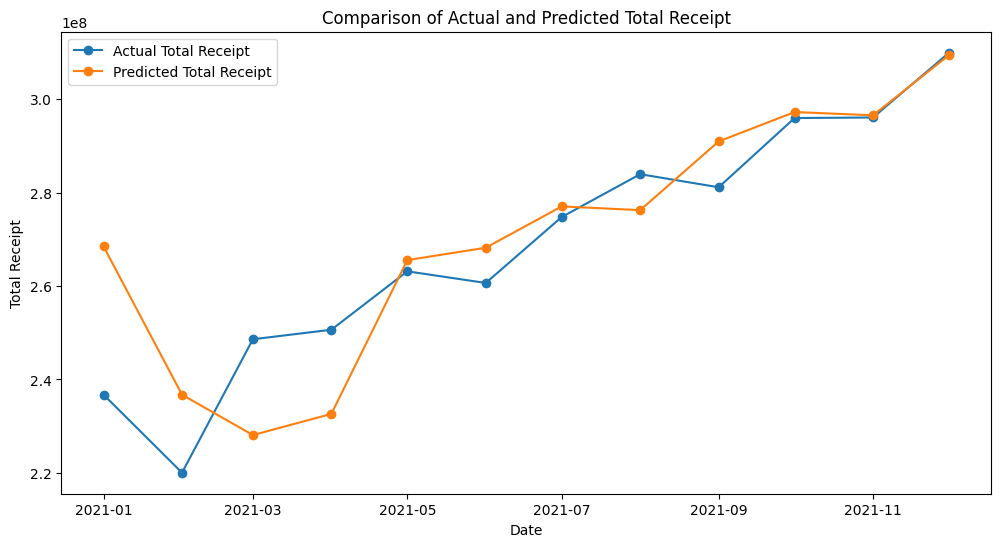

In [14]:
# Plot the best model predictions with the actual monthly data
monthly_data_2021.reset_index(inplace = True)
monthly_data_2021['Date'] = monthly_data_2021['Date'].astype('str')
monthly_data_2021['Date'] = pd.to_datetime(monthly_data_2021['Date'])

monthly_data_2021['Total_Receipt_Predictions'] = best_predictions

plt.figure(figsize=(12, 6))

plt.plot(monthly_data_2021['Date'], monthly_data_2021['Total_Receipt'], label='Actual Total Receipt', linestyle='-', marker='o')
plt.plot(monthly_data_2021['Date'], monthly_data_2021['Total_Receipt_Predictions'], label='Predicted Total Receipt', linestyle='-', marker='o')

# Titles and Axis Titles
plt.title('Comparison of Actual and Predicted Total Receipt')
plt.xlabel('Date')
plt.ylabel('Total Receipt')

# Legend
plt.legend()

plt.show()

###### **Building an Prophet Model**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxrfvfo2/lk0m5jzq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmppxrfvfo2/zm_o7inx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46454', 'data', 'file=/tmp/tmppxrfvfo2/lk0m5jzq.json', 'init=/tmp/tmppxrfvfo2/zm_o7inx.json', 'output', 'file=/tmp/tmppxrfvfo2/prophet_modelucijwv8p/prophet_model-20231114120945.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:09:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:

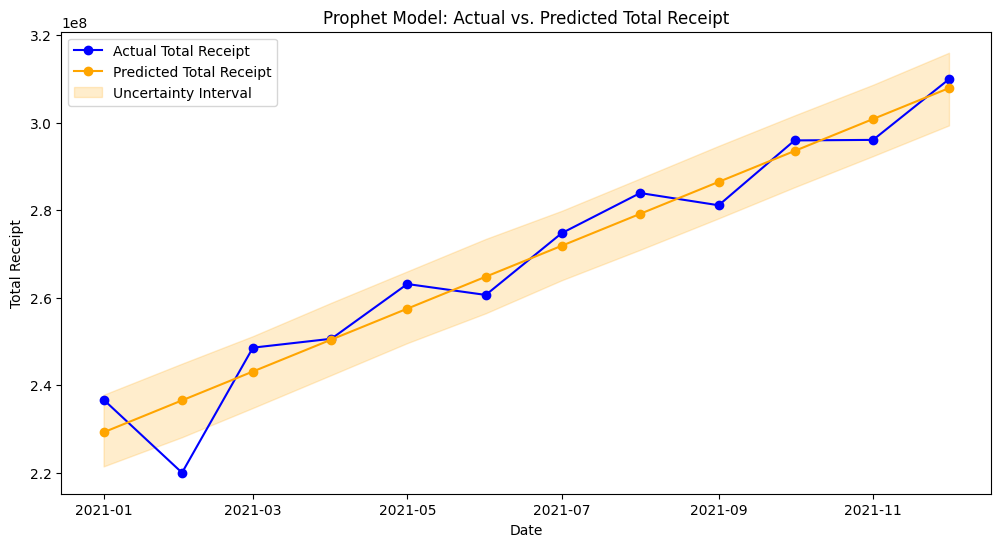

In [59]:
# Convert the data into Prophet format

data_prophet = monthly_data_2021.loc[:,['Date','Total_Receipt']].rename(columns={'Date': 'ds', 'Total_Receipt': 'y'})
# Fit the Prophet model
prophet_model = Prophet(scaling= 'minmax')
prophet_model.fit(data_prophet)

# Make predictions on monthly 2021 data
prophet_forecast = prophet_model.predict(data_prophet)

# Rename cols according to convenience
predictions_2021 = prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].rename(columns={'ds': 'Date', 'yhat': 'Total_Receipt_Predictions'})

# Plotting the original data and forecast
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data_prophet['ds'], data_prophet['y'], label='Actual Total Receipt', linestyle='-', marker='o', color='blue')
ax.plot(pd.to_datetime(predictions_2021['Date']), predictions_2021['Total_Receipt_Predictions'], label='Predicted Total Receipt', linestyle='-', marker='o', color='orange')

# Plotting uncertainty intervals
ax.fill_between(predictions_2021['Date'], predictions_2021['yhat_lower'], predictions_2021['yhat_upper'], color='orange', alpha=0.2, label='Uncertainty Interval')

# Titles and Axis Titles
plt.title('Prophet Model: Actual vs. Predicted Total Receipt')
plt.xlabel('Date')
plt.ylabel('Total Receipt')


# Legend
plt.legend()

# Show the plot
plt.show()

In [60]:
### Evaluation of the model

actual_values = data_prophet['y'].values
predicted_values = predictions_2021['Total_Receipt_Predictions']

# MAE
mae = mean_absolute_error(actual_values, predicted_values)

# MSE
mse = mean_squared_error(actual_values, predicted_values)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

Mean Absolute Error (MAE): 5135456.56
Mean Squared Error (MSE): 41671816417506.04


In [62]:
# Make inference on 2022 data

def predict_future_month(prophet_model, input_month):
    # Create a DataFrame for the input month
    future_month_df = pd.DataFrame({'ds': [input_month]})

    # Use the Prophet model to make predictions for the input month
    future_month_forecast = prophet_model.predict(future_month_df)

    # Extract the predicted value for the input month
    predicted_value = future_month_forecast['yhat'].values[0]

    return predicted_value

input_month = pd.to_datetime('2022-04')

predicted_value = predict_future_month(prophet_model, input_month)
print(f"Predicted Total Receipt for {input_month.strftime('%Y-%m')}: {predicted_value:.2f}")

Predicted Total Receipt for 2022-04: 336417088.20
